<a href="https://colab.research.google.com/github/201524495/2021_FSRnT/blob/main/Audio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [130]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [131]:
# Speech Commands 데이터 세트 가져 오기
data_dir = pathlib.Path('data/mini_speech_commands')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_command.zip',
      origin = "http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract = True,
      cache_dir = '.', cache_subdir = 'data')

In [132]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands : ', commands)

Commands :  ['go' 'stop' 'left' 'no' 'yes' 'down' 'up' 'right']


In [133]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples: ', num_samples)
print('Number of examples per label: ',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor: ', filenames[0])

Number of total examples:  8000
Number of examples per label:  1000
Example file tensor:  tf.Tensor(b'data/mini_speech_commands/up/88f8a99c_nohash_1.wav', shape=(), dtype=string)


In [134]:
train_files = filenames[:6400]
val_files = filenames[6400:6400+800]
test_files = filenames[-800:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 6400
Validation set size 800
Test set size 800


In [135]:
# 오디오 파일 및 레이블 읽기
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis = -1)

In [136]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)

  return parts[-2]

In [137]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [138]:
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls = AUTOTUNE)

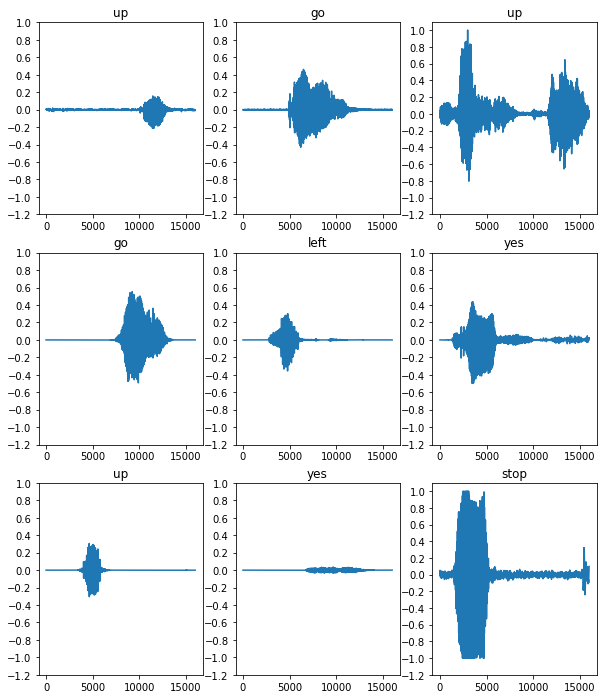

In [139]:
# 오디오 파형을 확인
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize = (10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

In [140]:
# 스펙트로 그램
def get_spectrogram(waveform):
  #
  zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype = tf.float32)

  # 
  # 
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length = 255, frame_step = 128)
  
  spectrogram = tf.abs(spectrogram)

  return spectrogram

In [141]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label', label)
print('Waveform shape: ', waveform.shape)
print('Spectrogram shape: ', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate = 16000))


Label up
Waveform shape:  (16000,)
Spectrogram shape:  (124, 129)
Audio playback


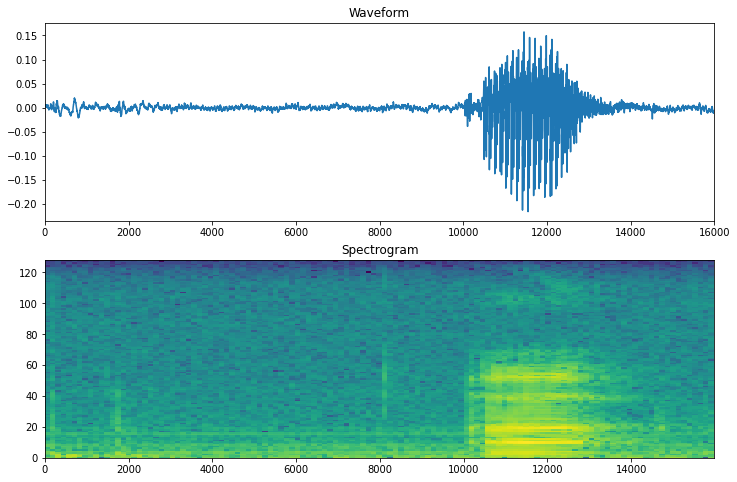

In [142]:
def plot_spectrogram(spectrogram, ax):
  #
  #
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  X = np.arange(16000, step = height + 1)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

fig, axes = plt.subplots(2, figsize = (12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [143]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

In [144]:
spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


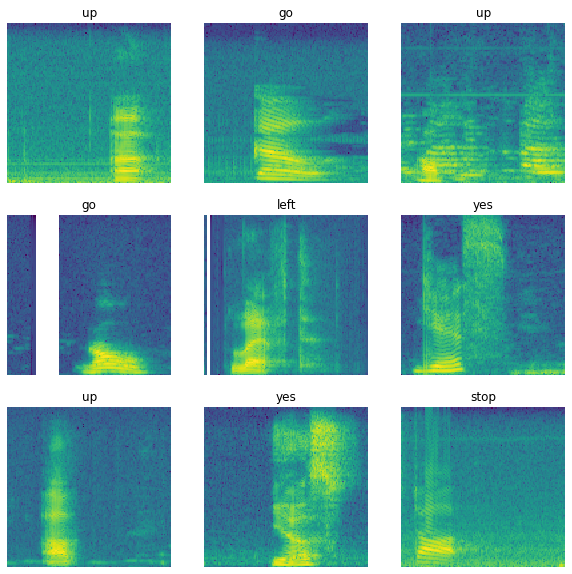

In [145]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize = (10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

In [146]:
# 모델 구축 및 훈련
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      get_spectrogram_and_label_id, num_parallel_calls = AUTOTUNE
  )
  return output_ds

In [147]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [148]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [149]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [150]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape: ', input_shape)
num_labels = len(commands)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

model = models.Sequential([
   layers.Input(shape = input_shape),
   preprocessing.Resizing(32, 32),
   norm_layer,
   layers.Conv2D(32, 3, activation = 'relu'),
   layers.Conv2D(64, 3, activation = 'relu'),
   layers.MaxPooling2D(),
   layers.Dropout(0.25),
   layers.Flatten(),
   layers.Dense(128, activation = 'relu'),
   layers.Dropout(0.5),
   layers.Dense(num_labels),
])

model.summary()

Input shape:  (124, 129, 1)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_2 (Resizing)        (None, 32, 32, 1)         0         
_________________________________________________________________
normalization_2 (Normalizati (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)       

In [151]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = ['accuracy']
)

In [152]:
EPOCHS = 10
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = EPOCHS,
    callbacks = tf.keras.callbacks.EarlyStopping(verbose = 1, patience = 2)
)

Epoch 1/10
100/100 [==============================] - 37s 364ms/step - loss: 1.9186 - accuracy: 0.2879 - val_loss: 1.3131 - val_accuracy: 0.5512
Epoch 2/10
100/100 [==============================] - 20s 196ms/step - loss: 1.3062 - accuracy: 0.5371 - val_loss: 0.9263 - val_accuracy: 0.6787
Epoch 3/10
100/100 [==============================] - 19s 194ms/step - loss: 0.9928 - accuracy: 0.6498 - val_loss: 0.8074 - val_accuracy: 0.7337
Epoch 4/10
100/100 [==============================] - 20s 196ms/step - loss: 0.8092 - accuracy: 0.7209 - val_loss: 0.7075 - val_accuracy: 0.7650
Epoch 5/10
100/100 [==============================] - 20s 195ms/step - loss: 0.6945 - accuracy: 0.7575 - val_loss: 0.6234 - val_accuracy: 0.7862
Epoch 6/10
100/100 [==============================] - 19s 195ms/step - loss: 0.6184 - accuracy: 0.7863 - val_loss: 0.5988 - val_accuracy: 0.7887
Epoch 7/10
100/100 [==============================] - 20s 197ms/step - loss: 0.5513 - accuracy: 0.8011 - val_loss: 0.5696 - val_ac

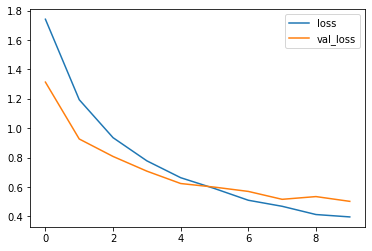

In [153]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [154]:
#테스트 세트 성능 평가
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [155]:
y_pred = np.argmax(model.predict(test_audio), axis = 1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 83%


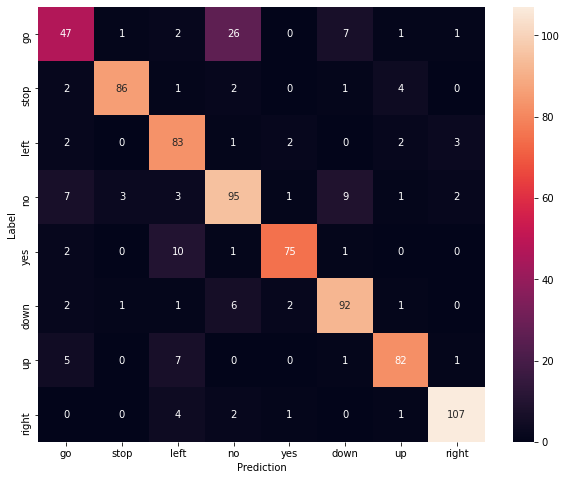

In [156]:
# 혼동 행렬 표시
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize = (10, 8))

sns.heatmap(confusion_mtx, xticklabels = commands, yticklabels = commands,
            annot = True, fmt = 'g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

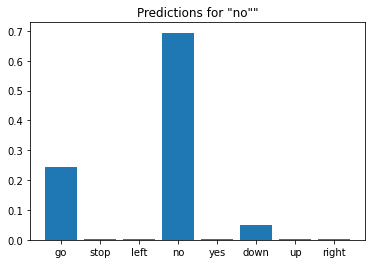

In [157]:
sample_file = data_dir/'no/01bb6a2a_nohash_0.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}""')
  plt.show()